Necessary imports
dataset: Represents mutations
model: GNN


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from model import *
from dataset import MutationDataset
from torch_geometric.loader import DataLoader
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import copy
import os
import time
from torch_geometric.loader import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ExponentialLR
writer = SummaryWriter(log_dir="tensorboard_runs")
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
make_dataset_threaded(index_xlsx="./renumbered_index.xlsx", root="dataset")

In [3]:
dataset = MutationDataset(index_xlsx="skempi_cleansed.xlsx", root="dataset")
train_size = int(len(dataset)*0.8042)
val_size = len(dataset)-train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

In [4]:
print("Length test dataset: ", len(val_dataset))
print("Length train dataset: ", len(train_dataset))

Length test dataset:  771
Length train dataset:  3163


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ddGPredictor().to(device)
device

'cuda'

In [6]:
optimizer = torch.optim.Adam(model.parameters())
scheduler = ExponentialLR(optimizer, gamma=0.9)
loss_fn =  nn.MSELoss()

In [20]:
k = 25
epochs = 500
model.train()

for epoch in tqdm(range(1, epochs)):
    epoch_loss = 0.
    best_loss = 1000.
    model.train()
    for i, batch in enumerate(train_loader) :
        x, y = batch["mutated"].to(device), batch["non_mutated"].to(device)
        ddg = x.ddg.to(device).squeeze()
        optimizer.zero_grad()
        out = model(x,y).squeeze()
        loss = loss_fn(out, ddg)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        clear_output(wait=True)
    epoch_loss/=len(train_loader)
    #if epoch%5==0:
        #scheduler.step()
    writer.add_scalar("RUN_{}/Loss/train".format(k), epoch_loss, epoch)
    print("Epoch: {}, Loss: {}".format(epoch, epoch_loss))
    
    if epoch%250==0 and epoch != 0:
        model.eval()
        val_loss = 0
        for i, batch in enumerate(val_loader):
            
            x, y = batch["mutated"].to(device), batch["non_mutated"].to(device)
            ddg = x.ddg.to(device).squeeze()
            out = model(x,y).squeeze()
            loss = loss_fn(out, ddg)
            val_loss+=loss.item()/len(val_dataset)
        print("Validation loss:", val_loss)
        
    
    if epoch_loss<best_loss:
        best_model = copy.deepcopy(model)
        
        torch.save(model.state_dict(), "model.pt")
    else:
        
        scheduler.step()

    

100%|██████████| 499/499 [3:45:15<00:00, 27.08s/it]

Epoch: 499, Loss: 2.038327212686892


In [17]:
d = next(iter(train_loader))
model(d["mutated"].cuda(), d["non_mutated"].cuda()).squeeze()

tensor(2.9291, device='cuda:0', grad_fn=<SqueezeBackward0>)

In [18]:
d["mutated"].ddg

tensor([2.5970], device='cuda:0')

100%|██████████| 100/100 [00:03<00:00, 29.50it/s]


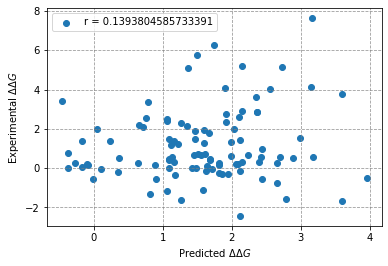

In [8]:
from src.visualize import comparator
model.load_state_dict(torch.load("model.pt"))
comparator(model, train_dataset,100, "cuda")

In [35]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import tune
from ray.tune.schedulers import ASHAScheduler

In [32]:
def train(model, optimizer, train_loader, writer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    epoch_loss=0
    for i, batch in enumerate(train_loader) :
        x, y = batch["mutated"].to(device), batch["non_mutated"].to(device)
        ddg = x.ddg.to(device).squeeze()
        optimizer.zero_grad()
        out = model(x,y).squeeze()
        loss = loss_fn(out, ddg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    writer.add_scalar("RUN/Loss/train", epoch_loss, epoch)
    print("Epoch Loss: {}".format(epoch_loss))

def test(model, data_loader, writer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    val_loss = 0
    with torch.no_grad():
        
        for i, batch in enumerate(val_loader):
            
            x, y = batch["mutated"].to(device), batch["non_mutated"].to(device)
            ddg = x.ddg.to(device).squeeze()
            out = model(x,y).squeeze()
            loss = loss_fn(out, ddg)
            val_loss+=loss.item()/len(val_dataset)
        print("Validation loss:", val_loss)
    return val_loss
    

In [33]:
def train_ddg(config):
    
    

    dataset = AffMutationDataset(index_xlsx="skempi_cleansed.xlsx", root="dataset")
    train_size = int(len(dataset)*0.8042)
    val_size = len(dataset)-train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size= 32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ddGPredictor(config).to(device)
    

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    
    for i in range(10):
        train(model, optimizer, train_loader, writer)
        acc = test(model, val_loader)

        # Send the current training result back to Tune
        tune.report(mean_accuracy=acc)

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")

In [40]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9),
    "features_in" : 20, 
    "features_hidden":30, 
    "gnn_features_out":tune.choice([30, 25, 20]), 
    "mlp_hidden_dim" : tune.choice([[30, 30, 30,], [50], [30], [20, 20], [20], [100], [100, 50], [1000], [1000, 500]]), 
    "out_dim":1
    
}

In [41]:
analysis = tune.run(train_dataset, config=search_space)

: 

: 

NameError: name 'spec' is not defined

In [ ]:
from graphein.protein.graphs import construct_graph
from graphein.ml.conversion import GraphFormatConvertor
from graphein.protein.edges.atomic import add_atomic_edges, add_bond_order, add_ring_status
from graphein.protein.edges.distance import add_hydrogen_bond_interactions, add_ionic_interactions, add_peptide_bonds
from graphein.protein.edges.distance import compute_distmat

from graphein.protein.config import ProteinGraphConfig
params_to_change = {"granularity": "atom", "edge_construction_functions": [add_atomic_edges, add_bond_order, add_hydrogen_bond_interactions, add_ionic_interactions, add_peptide_bonds]}
config = ProteinGraphConfig(**params_to_change)
graph_mutated = construct_graph(config=config,pdb_path="dataset/raw/temp/7_mutated_interface.pdb")

c:\ProgramData\Miniconda3\envs\bioinformatics\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
To use the Graphein submodule graphein.protein.features.sequence.embeddings, you need to install: biovec 
biovec cannot be installed via conda


Output()

c:\ProgramData\Miniconda3\envs\bioinformatics\lib\site-packages\pytorch3d\renderer\opengl\__init__.py:16: UserWarning: Can't import EGL, not importing MeshRasterizerOpenGL. This might happen if your Python application imported OpenGL with a non-EGL backend before importing PyTorch3D, or if you don't have pyopengl installed as part of your Python distribution.
  warnings.warn(


In [36]:
from graphein.protein.visualisation import plotly_protein_structure_graph

p = plotly_protein_structure_graph(
    graph_mutated,
    colour_edges_by="kind",
    colour_nodes_by="element_symbol",
    label_node_ids=False,
    node_size_min=5,
    node_alpha=0.85,
    node_size_multiplier=1,
    plot_title="Atom-level graph. Nodes coloured by their Element"
    )
p.show()

In [7]:
graph_mutated2 = construct_graph(config=config,pdb_path="dataset_3/raw/temp/0_mutated_interface.pdb")
p = plotly_protein_structure_graph(
    graph_mutated2,
    colour_edges_by="kind",
    colour_nodes_by="element_symbol",
    label_node_ids=False,
    node_size_min=5,
    node_alpha=0.85,
    node_size_multiplier=1,
    plot_title="Atom-level graph. Nodes coloured by their Element"
    )
p.show()

Output()

FileNotFoundError: [Errno 2] No such file or directory: 'dataset_3/raw/temp/0_mutated_interface.pdb'

In [37]:
format_convertor = GraphFormatConvertor('nx', 'pyg', verbose="default")


In [38]:
pyg_graph_mutated = format_convertor(graph_mutated)
from graphein.protein.edges.distance import add_hydrogen_bond_interactions, add_ionic_interactions, add_peptide_bonds
#config = ProteinGraphConfig()


# Create backbone graph with additional interactions
#edge_funcs = [add_hydrogen_bond_interactions, add_ionic_interactions, add_peptide_bonds]

#c#onfig = ProteinGraphConfig(edge_construction_functions= edge_funcs)
from graphein.protein.edges.distance import compute_distmat
##graph_mutated = construct_graph(config=config,pdb_path="dataset/raw/temp/0_mutated_interface.pdb")



In [40]:
pyg_graph_mutated.coords[0]

array([[ 7.793,  9.442, 21.943],
       [ 8.502, 10.692, 21.912],
       [ 9.68 , 10.668, 22.84 ],
       [ 9.733,  9.828, 23.738],
       [ 7.581, 11.863, 22.26 ],
       [ 6.866, 11.768, 23.546],
       [ 5.696, 11.136, 23.732],
       [ 7.169, 12.494, 24.779],
       [ 6.144, 12.182, 25.691],
       [ 8.264, 13.265, 25.247],
       [ 5.243, 11.372, 25.016],
       [ 6.121, 12.739, 26.968],
       [ 8.281, 13.773, 26.552],
       [ 7.211, 13.498, 27.417],
       [10.624, 11.613, 22.657],
       [11.733, 11.635, 23.577],
       [12.426, 12.958, 23.485],
       [11.857, 13.954, 23.053],
       [13.688, 12.904, 23.868],
       [14.597, 14.042, 23.873],
       [14.938, 14.39 , 22.444],
       [15.088, 13.475, 21.637],
       [15.88 , 13.626, 24.597],
       [17.065, 14.057, 23.948],
       [14.989, 15.689, 22.188],
       [15.308, 16.405, 20.951],
       [16.712, 16.052, 20.405],
       [17.022, 16.094, 19.212],
       [15.225, 17.924, 21.309],
       [14.198, 18.473, 20.53 ],
       [17

In [27]:
pyg_graph_mutated.edge_index[1, 2]

tensor(4)

In [28]:
dist_mat = dist_mat.to_numpy()

In [46]:
ei = pyg_graph_mutated.edge_index


In [32]:
edge_weights = []
for i in range(ei.shape[1]):
    edge_weights.append(1/dist_mat[ei[0, i].item(), ei[1, i].item()])
w = torch.tensor(edge_weights)

In [43]:
ei.reshape(ei.shape[1], ei.shape[0]).unique(dim =1).shape

torch.Size([181, 2])

In [47]:
torch_geometric.utils.coalesce(ei).shape

torch.Size([2, 181])

In [60]:
from graphein.protein.visualisation import plot_distance_matrix

plot_distance_matrix(graph_mutated)

KeyError: 'dist_mat'

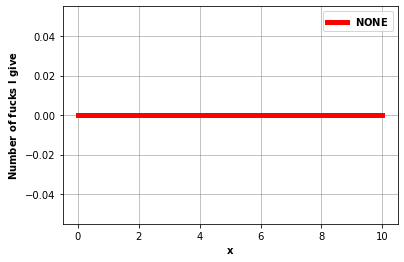

In [38]:
plt.plot([0, 10], [0, 0], label="$\\mathbf{NONE}$", c="r", linewidth=5)
plt.xlabel("$\\mathbf{x}$")
plt.ylabel("$\\mathbf{Number \\ of \\ fucks \\ I  \\ give}$")
plt.grid(c="grey", alpha=0.6)
plt.legend();

In [27]:
d = dataset[0]["mutated"]
d

Data(x=[92, 18], edge_index=[2, 173])

In [28]:
d.edge_weight

In [9]:
index_df = pd.read_excel("./renumbered_index.xlsx", converters={"pdb_id":str.lower, "mut_id":str.strip, "ddg":float, "res_renum":int})

In [10]:
d = np.array_split(index_df, 8)

In [12]:
d[0]

,pdb_id,mut_id,ddg,res_renum
0,1a4y,A:W261A,0.10,261
1,1a4y,A:W263A,1.17,263
2,1a4y,A:E287A,0.10,287
3,1a4y,A:S289A,0.04,289
4,1a4y,A:W318A,1.50,318
...,...,...,...,...
115,1iar,A:S16A,-0.18,16
116,1iar,A:S16D,-0.10,16
117,1iar,A:R53Q,0.84,53
118,1iar,A:K77A,0.15,77


In [1]:
import pymol2

In [3]:
p = pymol2.PyMOL()


In [4]:
p2 = pymol2.PyMOL()

In [6]:
mu = "a"

In [9]:
import os

In [18]:
def lower_filenames(dir):
    for file in os.listdir(dir):
        os.rename(os.path.join(dir, file), os.path.join(dir, file.lower()))



In [ ]:
os.listdir

In [19]:
lower_filenames("PDBs")

In [15]:
def remove_trash(dir):
    for item in os.listdir(dir):
        if item[0]=='.' or item.endswith(".mapping"):
            os.remove(os.path.join(dir, item))
        

In [16]:
remove_trash("PDBs")

In [19]:
import pandas as pd
mut_df = pd.read_excel("skempi_cleansed.xlsx", converters={"pdb_id":str.lower, "mut_pdb":str.strip,"mut_id":str.strip,"aff_mut":float, "aff_wt":float,"temp":float,  "ddg":float,})

In [20]:
mut_df["mut_id"] = mut_df["mut_id"].str.split(",")

In [21]:
mut_df = mut_df.loc[mut_df["mut_id"].str.len() == 1]

In [23]:
dropped = mut_df.dropna(axis=0)

In [27]:
dl = dropped.mut_id.to_list()

In [29]:
def f(x):
    return x[0]

In [31]:
dropped["mut_id"]=dropped["mut_id"].apply(f)

C:\Users\debab\AppData\Local\Temp\ipykernel_30552\3505691335.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped["mut_id"]=dropped["mut_id"].apply(f)


In [33]:
dropped.to_excel("index.xlsx")

In [10]:
mut_f = [x for x in os.listdir("dataset/processed/mutated") if x.endswith("mutated.pt")]



In [11]:
len(mut_f)

5103

In [71]:
import os
import shutil
sourcepath="dataset/processed"
sourcefiles = os.listdir("dataset/processed/")
destinationpath = "dataset/processed/non_mutated"
destmut =  "dataset/processed/mutated"
for file in sourcefiles:
    if file.endswith("_non_mutated.pt"):
        shutil.move(os.path.join(sourcepath,file), os.path.join(destinationpath,file))
    else:
        pass
        #shutil.move(os.path.join(sourcepath,file), os.path.join(destinationpath,file))   
